<a href="https://colab.research.google.com/github/cicattzo/mit_advanced_nlp/blob/main/HW4_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.864 Homework 4 - Question Answering

#1 Introduction
In this homework, we'll put together all the tools we've learned in this class to build a model for a more complex task: answering questions about written passages.

For this assignment, we'll start with pre-trained sentence representations from a model called DistilBERT (a smaller version of the BERT model we discussed in lecture). See the [paper](https://arxiv.org/pdf/1910.01108.pdf) for more info.

Note that the implementation of this homework for question answering is slightly different from the method introducted in the lecture - in order to let you know more possible solutions to the QA task.



##1.1 Overview
To build a question answering model from DistilBERT, we need to do the following

1. Download a pretrained DistilBERT model.
2. Add a task-specific answer prediction layer on top of DistilBERT's representations.
3. Fine-tune both DistilBERT and the answer prediction layer on a Q&A task.
4. Evaluate the trained Q&A model.

This assignment will also introduce you to a set of libraries from an organization called HuggingFace (yes, really) that are commonly used to access NLP datasets and pre-trained transformer models.



##1.2 Data
The dataset we will be using is the Stanford Question and Answer Dataset (SQuAD) v1.1. You can learn more about the dataset [here](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/). Just be careful to look at the v1.1 version, not v2. We'll download this model using the HuggingFace `datasets` package.



## 1.3 Pretrained model
You will install the HuggingFace `transformers` package. This package provides a wide variety of pretrained transformers. Check out out the [documentation](https://huggingface.co/transformers/) for more information.


## 1.4 Hardware
Make sure you've enabled GPU as a hardware accelerator for this notebook.


## 1.5 Important: Using Google Drive
It is highly recommended that you mount your Google Drive to Colab. The code provided to you assumes that you've already done that. Create a folder named `6864_hw4` in your Google Drive root directory and use the code below to mount it. The code should save everything (dataset, feature-ized data, trained models etc.) in the `6864_hw4` folder in your drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece 

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/gdrive/MyDrive/6864_hw4/"
cd "/content/gdrive/MyDrive/6864_hw4/"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/6864_hw4/’: File exists


Lets load the SQuAD dataset and observe its structure and data

In [3]:
from datasets import load_dataset

squad = load_dataset('squad')
print(squad)

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/0fd9e01360d229a22adfe0ab7e2dd2adc6e2b3d6d3db03636a51235947d4c6e9. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [4]:
for key, value in squad['train'][0].items():
    print(key)
    print(value)
    print('--------------------------')

answers
{'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}
--------------------------
context
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
--------------------------
id
5733be284776f41900661182
--------------------------
question
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
--------------------------
title
U

Notice that the `answers` in this dataset always consist of substrings of the `contexts`. Thus, like we discussed in class, we'll build a question-answering model by predicting the _locations_ of answers within contexts.

# 2 Introducing the Huggingface Toolkit

We'll be using two new packages:

- [transformers](https://github.com/huggingface/transformers). In this package,
    - **tokenizers** automatically convert strings into sequence of integer word piece IDs.
    - **models** provided architectures and weights for state-of-the-art pretrained transformer language models.
- [datasets](https://github.com/huggingface/datasets)
    - A toolkit that help you download and and evaluate your model on standard benchmarks easily
    - You can publish your own dataset on Huggingface [Datasets Hub](https://huggingface.co/datasets).

You can find more information and examples with the links above. The [demo notebook](https://drive.google.com/file/d/1_vx14SQkTyeWPW6lRR8_BHAO3urlfaQh/view?usp=sharing) for recitation 6 is also very helpful.



## 2.1 Tokenizers

If we're going to pass text to pretrained models, we need to make sure that the input text is pre-processed into sequences of token IDs in the same way as the training data. `tokenizers`  let us do this:

In [5]:
import transformers

# Use a pretrained tokenizer with CLASS.from_pretrained() function
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')

context = 'You can protect yourself by wearing an N95 mask.'
answer = 'wearing an N95 mask'

context_ids = tokenizer.encode(context)
print(context_ids)
print(tokenizer.convert_ids_to_tokens(context_ids))


[101, 1192, 1169, 3244, 3739, 1118, 3351, 1126, 151, 1580, 1571, 7739, 119, 102]
['[CLS]', 'You', 'can', 'protect', 'yourself', 'by', 'wearing', 'an', 'N', '##9', '##5', 'mask', '.', '[SEP]']


In [74]:
# ctx = 'split with Luckett and Roberson'
# ans = 'Luckett and Rober'

# ctx = 'The UK government has spent £250 million in the construction of the island'
# ans = '250 million'

ctx = 'You can protect yourself by wearing an N95 mask.'
ans = 'wearing an N95 mask'
verbose = True

start_loc = 0
end_loc = 0
ctx_enc = tokenizer(ctx, return_offsets_mapping=True, verbose=False)
ans_enc = tokenizer(ans, return_offsets_mapping=True)

if verbose:
  print(ctx_enc['input_ids'])
  print(ans_enc['input_ids'])
  print(tokenizer.convert_ids_to_tokens(ctx_enc['input_ids']))
  print(tokenizer.convert_ids_to_tokens(ans_enc['input_ids']))

ans_len = len(ans)
ctx_num_tok = len(ctx_enc['input_ids'])

ans_first_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]
ans_last_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]

# len_offset = 0

ix = 1
while start_loc==0 and end_loc==0:
  if ctx_enc['input_ids'][ix]==ans_enc['input_ids'][1]:
    start_loc = ix
    word_cts_offset = ctx_enc['offset_mapping'][ix]
    offset_start = word_cts_offset[0]
  if ctx_enc['input_ids'][ix]==ans_enc['input_ids'][-2]:
    end_loc = ix
    word_cts_offset = ctx_enc['offset_mapping'][ix]
    offset_end = word_cts_offset[1]
    # len_offset += word_cts_offset[1]-word_cts_offset[0]
  ix+=1

if end_loc==0:
  for ix in range(start_loc+1, ctx_num_tok):
    word_cts_offset = ctx_enc['offset_mapping'][ix]
    if word_cts_offset[1]-offset_start>=ans_len:
      end_loc = ix
      break

if start_loc==0:
  for ix in reversed(range(end_loc)):
    word_cts_offset = ctx_enc['offset_mapping'][ix]
    if offset_end-word_cts_offset[0]>=ans_len:
      start_loc = ix
      break
  
print(start_loc)
print(end_loc)

[101, 1192, 1169, 3244, 3739, 1118, 3351, 1126, 151, 1580, 1571, 7739, 119, 102]
[101, 3351, 1126, 151, 1580, 1571, 7739, 102]
['[CLS]', 'You', 'can', 'protect', 'yourself', 'by', 'wearing', 'an', 'N', '##9', '##5', 'mask', '.', '[SEP]']
['[CLS]', 'wearing', 'an', 'N', '##9', '##5', 'mask', '[SEP]']
6
11


In [65]:
ans_len

19

In [73]:
ctx_enc['offset_mapping'][6:-2]

[(28, 35), (36, 38), (39, 40), (40, 41), (41, 42), (43, 47)]

In [72]:
ans_enc['offset_mapping'][1:-1]

[(0, 7), (8, 10), (11, 12), (12, 13), (13, 14), (15, 19)]

In [37]:
ans_len

17

Notice that:

1. the tokenizer has inserted the special tokens `[CLS]` and `[SEP]` to mark the start and end of the sentence
2. the tokenizer has divided the word "N95" into three _word pieces_ `N`, `9` and `5` (refer to the Transformers lecture for a discussion of why we use these kinds of subword units). 

## Task 1: Complete the `ans_loc()` function

To practice working with tokenized text, implement the function below, which identifies the start and end locations of a tokenized phrase within a larger tokenized string. We'll use this function later to identify start and end locations for answers when we train a question answering model.

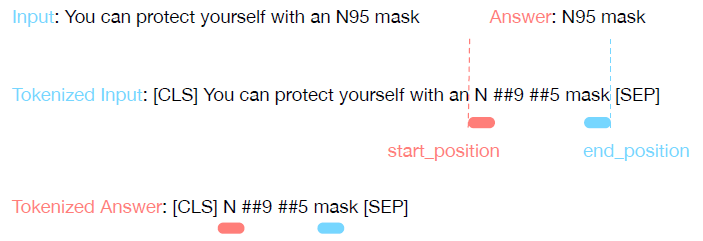

For example, if
- Context = [CLS], protect, yourself, with, an, N, ##9, ##5, mask, [SEP]
- Answer = [CLS], N, ##9, ##5, mask, [SEP]

The the answer location is
- Start postition: 5 (N)
- End postion: 8 (mask)

Hint: you need `ctx_enc['offset_mapping']` to pass all test cases. Refer to this [document](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__) for information about `offset_mapping`. Briefly speaking, offset_mapping is the character-level position of each token in the input text. for the `i`-th token in a input sequence,
```
st_char, ed_char = txt_enc['offset_mapping'][i]
token_id = txt_enc['input_ids'][i]
token_txt = txt_raw[st_char: ed_char]
```

In [75]:
def ans_loc(ctx, ans, verbose=False):

    start_loc = 0
    end_loc = 0
    ctx_enc = tokenizer(ctx, return_offsets_mapping=True, verbose=False)
    ans_enc = tokenizer(ans, return_offsets_mapping=True)

    if verbose:
        print(ctx_enc['input_ids'])
        print(ans_enc['input_ids'])
        print(tokenizer.convert_ids_to_tokens(ctx_enc['input_ids']))
        print(tokenizer.convert_ids_to_tokens(ans_enc['input_ids']))

    # ------------ Your Code Starts ------------- #
    ans_len = len(ans)
    ctx_num_tok = len(ctx_enc['input_ids'])

    ans_first_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]
    ans_last_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]

    # len_offset = 0

    ix = 1
    while start_loc==0 and end_loc==0:
      if ctx_enc['input_ids'][ix]==ans_enc['input_ids'][1]:
        start_loc = ix
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        offset_start = word_cts_offset[0]
      if ctx_enc['input_ids'][ix]==ans_enc['input_ids'][-2]:
        end_loc = ix
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        offset_end = word_cts_offset[1]
        # len_offset += word_cts_offset[1]-word_cts_offset[0]
      ix+=1

    if end_loc==0:
      for ix in range(start_loc+1, ctx_num_tok):
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        if word_cts_offset[1]-offset_start>=ans_len:
          end_loc = ix
          break

    if start_loc==0:
      for ix in reversed(range(end_loc)):
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        if offset_end-word_cts_offset[0]>=ans_len:
          start_loc = ix
          break

    
    # ------------ Your Code Ends --------------- #

    return start_loc, end_loc

Test your implementation with the following cases

In [76]:
# -------------- Test Case 1 ----------------- #

print('------------- Test Case 1 -------------')
ctx_c1 = 'You can protect yourself by wearing an N95 mask.'
ans_c1 = 'wearing an N95 mask'

start_loc, end_loc = ans_loc(ctx_c1, ans_c1, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')

if (start_loc, end_loc) == (6, 11):
    print('\nYour implementation is correct for case 1')
else:
    print('\nYour implementation failed on case 1')

# -------------- Test Case 2 ----------------- #

print('\n------------- Test Case 2 -------------')
ctx_c2 = 'split with Luckett and Roberson'
ans_c2 = 'Luckett and Rober'

start_loc, end_loc = ans_loc(ctx_c2, ans_c2, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')
if (start_loc, end_loc) == (3, 7):
    print('\nYour implementation is correct for case 2')
else:
    print('\nYour implementation failed on case 2')

# -------------- Test Case 3 ----------------- #

print('\n------------- Test Case 3 -------------')
ctx_c2 = 'The UK government has spent £250 million in the construction of the island'
ans_c2 = '250 million'

start_loc, end_loc = ans_loc(ctx_c2, ans_c2, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')
if (start_loc, end_loc) == (6, 8):
    print('\nYour implementation is correct for case 3')
else:
    print('\nYour implementation failed on case 3')

------------- Test Case 1 -------------
[101, 1192, 1169, 3244, 3739, 1118, 3351, 1126, 151, 1580, 1571, 7739, 119, 102]
[101, 3351, 1126, 151, 1580, 1571, 7739, 102]
['[CLS]', 'You', 'can', 'protect', 'yourself', 'by', 'wearing', 'an', 'N', '##9', '##5', 'mask', '.', '[SEP]']
['[CLS]', 'wearing', 'an', 'N', '##9', '##5', 'mask', '[SEP]']
The start location is 6, and the end location is 11

Your implementation is correct for case 1

------------- Test Case 2 -------------
[101, 3325, 1114, 22311, 5912, 1105, 6284, 18608, 102]
[101, 22311, 5912, 1105, 6284, 1200, 102]
['[CLS]', 'split', 'with', 'Luck', '##ett', 'and', 'Rob', '##erson', '[SEP]']
['[CLS]', 'Luck', '##ett', 'and', 'Rob', '##er', '[SEP]']
The start location is 3, and the end location is 7

Your implementation is correct for case 2

------------- Test Case 3 -------------
[101, 1109, 1993, 1433, 1144, 2097, 24155, 11049, 1550, 1107, 1103, 2058, 1104, 1103, 2248, 102]
[101, 4805, 1550, 102]
['[CLS]', 'The', 'UK', 'government'

Another useful feature of the tokenizer is the `batch_encode_plus function`, which returns both input IDs and attention masks. For example,



In [77]:
ctx1 = 'I am a short sentence'
ctx2 = 'I am a long long long long long long long sentence'
ctx_list = [ctx1, ctx2]

inputs = tokenizer.batch_encode_plus(
    ctx_list,
    max_length = 12,
    truncation=True,
    padding='longest',
    return_attention_mask=True,
    return_tensors='pt'
)

for key, value in inputs.items():
    print(key)
    print(value)
    print('-------------------------')

input_ids
tensor([[ 101,  146, 1821,  170, 1603, 5650,  102,    0,    0,    0,    0,    0],
        [ 101,  146, 1821,  170, 1263, 1263, 1263, 1263, 1263, 1263, 1263,  102]])
-------------------------
attention_mask
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
-------------------------


## 2.2 Models

After converting the input texts into ids with corresponding attention masks, we can obtain the hidden state of each word by feeding the input IDs into a Transformer network. We will use the output hidden states to predict the start and end locations of the target answer.

## Sanity Check: Input and Output Shapes of DistilBertModel

Please read the [source code](https://huggingface.co/transformers/_modules/transformers/models/distilbert/modeling_distilbert.html#DistilBertModel) and [document](https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertModel) of the DistilBertModel class.

Suppose we train a question-answering model based on a DistilBertModel. The batch size of the training inputs is `batch_size`, the maximum sequence length of the input batch is `seq_length`. In other words, the input shape of our model is `[batch_size, seq_length]`. Please answer the following questions to examine if you have understood the class we are going to use,

- What is the shape of the top-layer hidden states?

- According to the [document](https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertModel) and the `outputs` above, what are potential outputs of the `DistilBertModel`?

If you are not sure if your answers are correct, we encourage you to practice with code to examine your answers.
(No need to include this in your write-up---this is just here to help you debug).




# 3 Building a Question Answering Model

Now that we have access to pre-trained representations, let's start building a question answering model!



## 3.1 Pre-processing the SQuAD data

We preprocess each data point of SQuAD by calculating the start and end positions with the selected tokenizer. In this homework we use the `distilbert-base-cased` model, so we use the `distilbert-base-cased` tokenizer to preprocessing the data. If you want to try other models, please make sure you are using the correct pair of model and tokenizer.



## Task 2: Complete the `proc_line()` function

In [ ]:
import json
import random
from multiprocessing import Pool
from tqdm import tqdm, trange

def proc_line_init(tokenizer_for_squad):
    global tokenizer
    tokenizer = tokenizer_for_squad

# Preprocess one SQuAD data point
def proc_line(sq):
    ctx = sq['context']
    ans = sq['answers']['text'][0]

    ctx_ids = tokenizer.encode(ctx, verbose=False)
    ans_ids = tokenizer.encode(ans)

    if len(ctx_ids) > 448:
        return None

    start_pos = None
    end_pos = None
    
    # Get the values of start and end pos
    #
    # ----- Your code: get the start and end positions ------ #
    # ----- with the `ans_loc` function you defined --------- #
    
    start_pos, end_pos = # ? #
    
    # ---------------- End of your code --------------------- #

    sq['start_position'] = start_pos
    sq['end_position'] = end_pos
    return sq

# Preprocess SQuAD corpus with tqdm multithreading
def preproc(squad_list, threads, tokenizer):

    with Pool(threads, initializer=proc_line_init, initargs=(tokenizer,)) as p:
        squad_proc = list(tqdm(p.imap(proc_line, squad_list), total=len(squad_list)))

    squad_proc = [x for x in squad_proc if x]
    json.dump(squad_proc, open("/content/gdrive/My Drive/6864_hw4/squad_proc.json", 'w'))
    return squad_proc

squad_list = [x for x in squad['train']]
squad_proc = preproc(squad_list, 16, tokenizer)

We test the correctness of the preprocessed data by randomly selecting data points.

In [ ]:
# Test if your preprocessing is correct
def test_preproc(sq, tokenizer):
    gt_ans = sq['answers']['text'][0]
    start_pos = sq['start_position']
    end_pos = sq['end_position']

    tok_outputs = tokenizer(sq['context'], return_offsets_mapping=True)
    ctx_ids = tok_outputs['input_ids']
    offsets = tok_outputs['offset_mapping']

    start_pos_char = offsets[start_pos][0]
    end_pos_char = offsets[end_pos][1]

    pred_ans = sq['context'][start_pos_char: end_pos_char]

    print(f'The annotated answer: {gt_ans} .')
    print(f'The predicted answer: {pred_ans} .')
    if gt_ans == pred_ans:
        print('Pass')
    else:
        print('Something went wrong')

test_preproc(random.choice(squad_proc), tokenizer)

## Task 3: complete the `QuestionAnsweringModel` class

- Read the document of [DistilBERT.forward()]() to understand the inputs and outputs of a Huggingface transformer model, and figure out how to extract representations from the encoder.
- Complete the `forward` function. This function should place logits over start positions and end positions (`log p(start | C, Q)` and `log p(end | C, Q)`), and return the predicted logits. It should also return losses if `start_positions` and `end_positions` are provided.
    - Feed the hidden states into the 1. dropout layer, and 2. linear layer to predict the start and end logits
    - Calculate `start_loss` and `end_loss` with `nn.CrossEntropyLoss` with predicted `start/end_logits` and labeled `start/end_positions` as two seperate classification tasks.
    - Return predicted `start_logits, end_logits` and `total_loss = (start_loss + end_loss) / 2`.

In [ ]:
import torch.nn as nn

class ModelOutputs:
    def __init__(self, start_logits=None, end_logits=None, loss=None):
        self.start_logits = start_logits
        self.end_logits = end_logits
        self.loss = loss

class QuestionAnsweringModel(nn.Module):

    def __init__(self, lm=None, dropout=0.2):
        '''
        lm:         a pretrained transformer language model
        dropout:    dropoutrate for the dropout layer
        '''
        super(QuestionAnsweringModel, self).__init__()
        self.qa_outputs = nn.Linear(lm.config.dim, 2)
        self.lm = lm
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids=None, attention_mask=None,
                start_positions=None, end_positions=None):
        '''
        input_ids:          ids of the concatenated input tokens
        attention_mask:     concatenated attention masks (ques+ctx)
        start_positions:    labels of the start positions of the answers
        end_positions:      labels of the end positions of the answers
        '''
        
        lm_output = self.lm(
            # ----- Your code: Model inputs ----- #

            # -------- Your code ends ----------- #
        )

        hidden_states = # -- Hidden states of the top transformer layer -- #
        hidden_states = self.dropout(hidden_states)

        start_logits = None
        end_logits = None

        # ----- Get start_logits and end_logits ----------------- #
        #
        # start_logits.size() should be [batch_size, seq_len]
        # end_logits.size() should also be [batch_size, seq_len]
        #
        # ----------------- Your code --------------------------- #

        
        # -------- End of your code for logits calculation ------ #

        total_loss = None
        if start_positions is not None and end_positions is not None:

            loss_fct = nn.CrossEntropyLoss()
            
            # ----- Getting training losses ------------------- #
            #
            # 1. calculate start_losses with
            #       a. start_logits
            #       b. start_positions
            #
            # 2. calculate end_losses with end_logits
            #       a. end_logits
            #       b. end_positions
            #
            # --------- Your code starts ---------------------- #

            start_loss = # Your code #
            end_loss = # Your code #

            # --------- Your code ends ------------------------ #

            total_loss = (start_loss + end_loss) / 2
        
        return ModelOutputs(
            start_logits=start_logits,
            end_logits=end_logits,
            loss=total_loss)

## 3.3 Training the DistilBERT Model

First, we move our model to the GPU. 

In [ ]:
# Initialize the QA model and use GPU
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
model = QuestionAnsweringModel(lm_pretrained)
model = model.cuda()

Then we define the training hyper-parameters, the optimizer, and the learning rate scheduler. Read this [document](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) to understand how the linear learning rate scheduling influences the learning process.

In [ ]:
import torch

# Hyper-parameters: you could try playing with different settings
num_epochs = 1
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 32
warmup_rate = 0.05
ques_max_length = 64
ctx_max_length = 448

# Calculating the number of warmup steps
num_training_cases = len(squad_proc)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

[link text](https://)We need a function that processes batch data into the input format needed by DistilBERT. We first gather contexts, questions, etc in a batch into their corresponding lists.

In [ ]:
def gather_batch(batch):
    ctx_batch  = [x['context'] for x in batch]
    ques_batch = [x['question'] for x in batch]
    ans_batch  = [x['answers']['text'][0] for x in batch]

    start_positions = [x['start_position'] for x in batch]
    end_positions = [x['end_position'] for x in batch]

    return ctx_batch, ques_batch, ans_batch, start_positions, end_positions

and then we encode the texts with the DistilBERT tokenizer, and then process the inputs into the following format:

```
[CLS] <question ids> [SEP] <context ids> [SEP]
```

as you can find out, the inputs of our DistilBERT model is the concatenated question word IDs and context word IDs, marked and seperated by special tokens. Note that besides input IDs, we also need to re-organize the attention masks into the same format. We provide the function for this process, and we encourage you to read the code - should be helpful to your course project and future work.

After we concatenate the context to the question, the start and end positions in the context are off by a constant factor. Please fix start_positions and end_positions below.

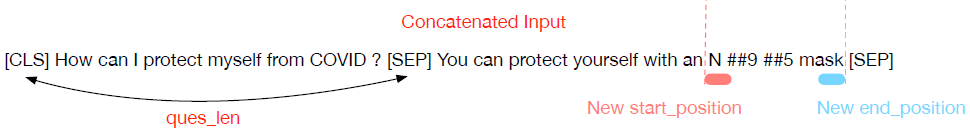



In [ ]:
def vectorize_batch(batch, tokenizer):
    ctx_batch, ques_batch, ans_batch, start_positions, end_positions = gather_batch(batch)

    # Encode the context passage
    ctx_encode = tokenizer.batch_encode_plus(
        ctx_batch,
        max_length = ctx_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # Encode the questions
    ques_encode = tokenizer.batch_encode_plus(
        ques_batch,
        max_length = ques_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # Get the actual sequence lengths of question tensors
    ques_seq_len = ques_encode['input_ids'].size(1)

    # Move the training batch to GPU
    ctx_ids        = ctx_encode['input_ids'].cuda()
    ctx_attn_mask  = ctx_encode['attention_mask'].cuda()
    ques_ids       = ques_encode['input_ids'].cuda()
    ques_attn_mask = ques_encode['attention_mask'].cuda()

    # Remove the [CLS] token of the contexts IDs before concatenation
    ctx_ids = ctx_ids[:, 1:]
    ctx_attn_mask = ctx_attn_mask[:, 1:]

    # Concatenate questions and contexts
    input_ids = torch.cat([ques_ids, ctx_ids], dim=1)
    input_attn_mask = torch.cat([ques_attn_mask, ctx_attn_mask], dim=1)

    # Move start and end positions to the GPU
    start_positions = torch.LongTensor(start_positions).cuda()
    end_positions   = torch.LongTensor(end_positions).cuda()

    # update the start_positions and end_positions variables accordingly
    # This is necessary for the following reasons
    # 
    # 1. We concatenated the questions and contexts
    # 2. We removed the [CLS] token (the first token) of the contexts

    start_positions += ques_seq_len - 1
    end_positions += ques_seq_len - 1

    return input_ids, input_attn_mask, start_positions, end_positions

and we can start the training loop, which includes the following steps for processing each mini-batch
- Tokenize questions and contexts, then concatenate the input IDs of questions and corresponding contexts
- Feed the concatenated inputs into the Transformer model
- Optimize the model by back-propagating the loss signals

## Task 4: Complete the code for feeding the inputs to the Transformer model

Hint: Read the implementation of the `forward()` method of the `QuestionAnsweringModel` class to decide the input format.

If you get CUDA out of memory error, do "Manage sessions" -> "TERMINATE" -> "Reconnect" -> Re-run necessary code cells
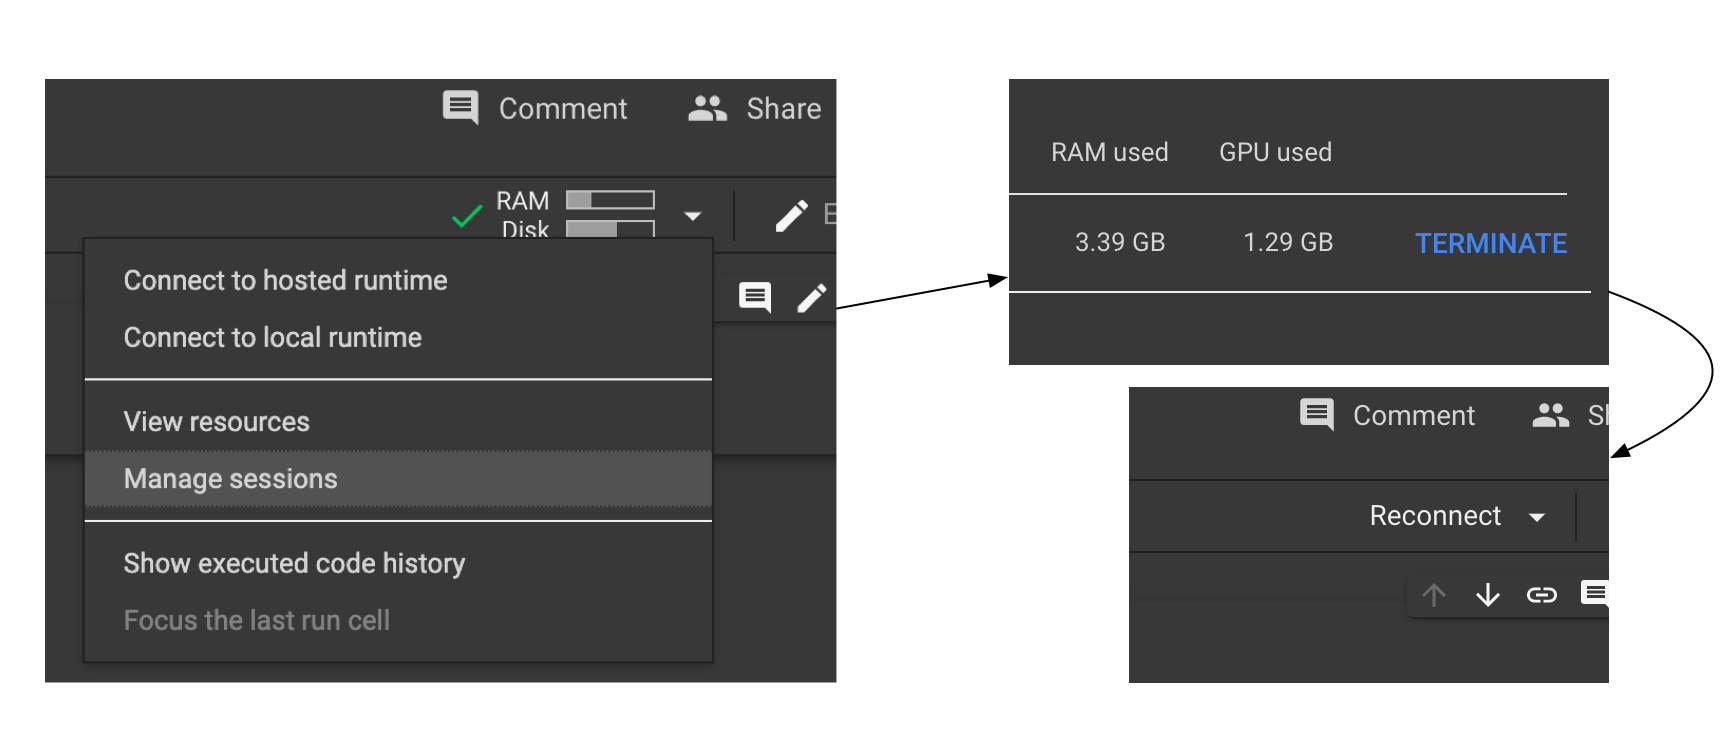

In [ ]:
model.train()
max_grad_norm = 1

'''
The training can take up to an hour (~50min in average)
Consider using less training data to validate your implementation
'''
# squad_proc = squad_proc[:10000]
# num_training_cases = len(squad_proc)

step_id = 0
for _ in range(num_epochs):

    random.shuffle(squad_proc)

    for i in range(0, num_training_cases, batch_size):
        batch = squad_proc[i: i + batch_size]
        input_ids, input_attn_mask, start_positions, end_positions = vectorize_batch(batch, tokenizer)

        model.zero_grad() # Does the same as ext_optim.zero_grad()
        
        # Get the model outputs, including (start, end) logits and losses
        # stored as a ModelOutput object
        outputs = model(            
            # --------------------------------------------------- #
            #
            # Read your QuestionAnsweringModel.forward(...)
            # implementation for the input format
            #
            # ------------------ Your code starts --------------- #
       

            # ------------------ Your code ends ----------------- #
        )

        # Back-propagate the loss signal and clip the gradients
        loss = outputs.loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update neural network parameters and the learning rate
        ext_optim.step()
        ext_sche.step() # Update learning rate for better convergence


        if step_id % 100 == 0:
            print(f'At step {step_id}, the extraction loss = {loss}')
        
        step_id += 1

print('Finished Training')



# 4 Evaluating the Learned QA Model

Standard evaluation metrices for extractive, or span-based QA models are exact match (EM) and F1 scores.
- EM: how many predicted answers are exactly the same as the annotated answers
- F1: how many words in the predicted answers overlap the annotated answers.

In other words, the calculations of EM and F1 scores are:
- EM = num_same_answer / num_all_questions
- F1 = (2 * precision * recall) / (precision + recall), where
    - precision = num_overlap_words / num_predicted_answer_words
    - recall = num_overlap_words / num_annotated_answer_words


In [ ]:
def ans_pair_metric(a_pred, a_gt, tokenizer):
    '''
    a_pred: the predicted answer text
    a_gt: the groundtruth answer text
    '''
    
    # Exclude the special tokens
    pred_ids = tokenizer.encode(a_pred)[1: -1]
    gt_ids = tokenizer.encode(a_gt)[1: -1]

    len_pred = len(pred_ids)
    len_gt = len(gt_ids)
    num_same = 0
    for word_id in pred_ids:
        if word_id in gt_ids:
            num_same += 1.
    
    em = float(a_pred == a_gt)
    if num_same == 0:
        f1 = 0
    else:
        prec = num_same / len_pred
        recall = num_same / len_gt
        f1 = 2 * prec * recall / (prec + recall)

    return em, f1

In SQuAD, some context passages are annotated with many possible answers that are considered correct, and we compare our predicted answer with the most similar annotated answer.

In [ ]:
import numpy as np

def one_to_many_metric(a_pred, a_gt_list, tokenizer):
    '''
    a_pred: the predicted answer text
    a_gt_list: the provided ground-truth answer list
    '''
    metric = np.array([ans_pair_metric(a_pred, x, tokenizer) for x in a_gt_list])

    em = metric[:, 0]
    f1 = metric[:, 1]
    return em.max(), f1.max()

We will also need to have a function that infers the locations of answers based on the predicted start and end locations.

## Task 5: complete the `logits_to_ans_loc` function

`logits_to_ans_loc` is a decoding function that converts predicted start and end logits to an actual answer span $(i, j)$, where
- word $w_i$ has a high `start_logit`
- word $w_j$ has a high `end_logit`.

Inputs and outputs
- inputs: `start_logits` and `end_logits`
- outputs
    - st_loc: the index of the start TOKEN (not character) of the predicted answer
    - ed_loc: the index of the end TOKEN of the predicted answer

Note:
- we don't consider answers more than 30 tokens
- Make sure `ed_loc >= st_loc`
- Higher start/end logits stands for higher probability that a word could be the start/end point of an answer
- Please implement three strategies for getting answer span $(i, j)$
    - `greedy_left_to_right` - Select $i = argmax_i \ S_{start}^i$, then select $j = argmax_j \ S_{end}^j$. ($i \le j$)
    - `greedy_right_to_lett` - Select $j = argmax_j \ S_{end}^j$, then select $i = argmax_i \ S_{start}^i$ ($i \le j$)
    - `joint` - Select $(i, j)$ by $$i, j = argmax_{i, j} \ S_{start}^i + S_{end}^j \ (i \le j) $$ 
    - Compare the performance

In [ ]:
def logits_to_ans_loc(start_logits, end_logits, mode='joint'):
    '''

    Input sizes -
        start_logits.size() = [batch_size, seq_len]
        end_logits.size() = [batch_size, seq_len]

    Output sizes -
        st_loc.size() = (batch_size,)
        ed_loc.size() = (batch_size,)

    '''
    bs, seq_len = start_logits.size()

    st_loc = None
    ed_loc = None
    
    # Find the span (i, j) that could be an answer
    # to the question, based on the predicted
    # start_logits and end_logits with three modes
    #   - greedy_left_to_right
    #   - greedy_right_to_left
    #   - joint
    #
    # ------------ Your code starts -------------- #

    # tensor( [[0, 1, ..., seq_len - 1]] )
    # pos_idx.size() = (1, seq_len)
    pos_idx = torch.range(0, seq_len - 1).cuda().unsqueeze(0)
    
    if mode == 'greedy_left_to_right':
        # Your code #

    if mode == 'greedy_right_to_left':
        # Your code #

    if mode == 'joint':
        # Your code #


    # ------------ Your code ends ---------------- #
    
    return st_loc, ed_loc

and now we start implementing the evaluation loop

## Task 6: complete the evaluation loop

In [ ]:
model.eval()

# Prepare the dev set of SQuAD for evaluation
dev_set = [x for x in squad['validation']]
num_dev_cases = len(dev_set)

eval_batch_size = 64

# `ans_pred_list` stores the predicted answers
# in the same order as the contexts of the dev set
ans_pred_list_ltr = []
ans_pred_list_rtl = []
ans_pred_list_joint = []
ans_gt_list = [x['answers']['text'] for x in dev_set]

for i in range(0, num_dev_cases, eval_batch_size):
    eval_batch = dev_set[i: i + eval_batch_size]
    ques = [x['question'] for x in eval_batch]
    ctx  = [x['context'] for x in eval_batch]

    # Encode the contexts
    ctx_encode = tokenizer.batch_encode_plus(
        ctx,
        max_length = ctx_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt',
        return_offsets_mapping = True
    )

    # Encode the questions
    ques_encode = tokenizer.batch_encode_plus(
        ques,
        max_length = ques_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # get the actual question sequence lengths
    ques_len = ques_encode['input_ids'].size(1)

    # ------------- Your code Part 1 -------------- #
    #
    # concatenate the input ids and attention masks
    # of questions and contexts. Refer to the training
    # loop for implementation hints
    #
    # --------------------------------------------- #
    
    input_ids = torch.cat(
        [], # what tensors to concatenate
        dim = # on which dimension?
    ).cuda()

    input_attn_mask = torch.cat(
        [], # what tensors to concatenate
        dim = # on which dimension?
    ).cuda()

    # ------------- Your code Part 1 ends ---------- #

    with torch.no_grad():
        outputs = model(
            input_ids,
            attention_mask = input_attn_mask,
        )
    
    # ------------- Your code Part 2 --------------- #
    #
    # Obtain the predicted start and end logits
    # We drop the start and end logits of question tokens
    # and only keep the logits of
    #
    #       [SEP] or [PAD], ctx_1, ctx_2, ..., [SEP]
    #
    # keep the first special token, which is the tail
    # or padding token of the tokenized question, to
    # help you do later decoding more easily 
    #
    # ---------------------------------------------- # 
    
    start_logits_pred = # Your code #
    end_logits_pred = # Your code #

    # ------------- Your code Part 2 ends ---------- #

    st_locs_ltr, ed_locs_ltr = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='greedy_left_to_right'
    )

    st_locs_rtl, ed_locs_rtl = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='greedy_right_to_left'
    )
    
    st_locs_joint, ed_locs_joint = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='joint'
    )

    num_pred_answer = st_locs_ltr.size(0)

    # ---------------------------------------------- #
    #
    # Store predicted answer texts in `ans_pred_list`
    # 1. `ans_pred_list` should look like
    #             ['ans_txt_1', 'ans_txt_2', ....]
    #
    # 2. `len(ans_pred_list)` should equas to
    #             `len(dev_set)`
    #
    # ---------------------------------------------- #
    
    for j in range(num_pred_answer):
        st_char_ltr = ctx_encode['offset_mapping'][j][st_locs_ltr[j]][0]
        ed_char_ltr = ctx_encode['offset_mapping'][j][ed_locs_ltr[j]][1]
        ans_pred_list_ltr.append(ctx[j][st_char_ltr: ed_char_ltr])

        st_char_rtl = ctx_encode['offset_mapping'][j][st_locs_rtl[j]][0]
        ed_char_rtl = ctx_encode['offset_mapping'][j][ed_locs_rtl[j]][1]
        ans_pred_list_rtl.append(ctx[j][st_char_rtl: ed_char_rtl])

        st_char_joint = ctx_encode['offset_mapping'][j][st_locs_joint[j]][0]
        ed_char_joint = ctx_encode['offset_mapping'][j][ed_locs_joint[j]][1]
        ans_pred_list_joint.append(ctx[j][st_char_joint: ed_char_joint])
    
    # ---------------------------------------------- #

# Print the evaluation results
#
# The performance is decided by both training quality
# AND the implementation of the `logits_to_anc_loc` function

# Target result
# - EM: 67.97%
# - F1: 80.89%

print('Evaluating greedy_left_to_right strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_ltr, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')

# Target result
# - EM: 67.97%
# - F1: 80.89%

print('\nEvaluating greedy_right_to_left strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_rtl, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')

# Target result
# - EM: 68.99%
# - F1: 81.77%

print('\nEvaluating joint strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_joint, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')